In [1]:
import torch

path = "cora/"
cites = path + "cora.cites"
content = path + "cora.content"

# 索引字典，将原本的论文id转换到从0开始编码
index_dict = dict()
# 标签字典，将字符串标签转化为数值
label_to_index = dict()

features = []
labels = []
edge_index = []

with open(content,"r") as f:
    nodes = f.readlines()
    for node in nodes:
        node_info = node.split()
        index_dict[int(node_info[0])] = len(index_dict)
        features.append([int(i) for i in node_info[1:-1]])
        
        label_str = node_info[-1]
        if(label_str not in label_to_index.keys()):
            label_to_index[label_str] = len(label_to_index)
        labels.append(label_to_index[label_str])

with open(cites,"r") as f:
    edges = f.readlines()
    for edge in edges:
        start, end = edge.split()
        # 训练时将边视为无向的，但原本的边是有向的，因此需要正反添加两次
        edge_index.append([index_dict[int(start)],index_dict[int(end)]])
        edge_index.append([index_dict[int(end)],index_dict[int(start)]])

# 为每个节点增加自环，但后续GCN层默认会添加自环，跳过即可
# for i in range(2708):
#     edge_index.append([i,i])
  
# 转换为Tensor
labels = torch.LongTensor(labels)
features = torch.FloatTensor(features)
# 行归一化
# features = torch.nn.functional.normalize(features, p=1, dim=1)
edge_index =  torch.LongTensor(edge_index)



In [2]:
class GCNNet(torch.nn.Module):
    def __init__(self, num_feature, num_label):
        super(GCNNet,self).__init__()
        self.GCN1 = GCNConv(num_feature, 16)
        self.GCN2 = GCNConv(16, num_label)  
        self.dropout = torch.nn.Dropout(p=0.5)
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        x = self.GCN1(x, edge_index)
        x = F.relu(x)
 
        x = self.GCN2(x, edge_index)
        
        return F.log_softmax(x, dim=1)


In [3]:
class GATNet(torch.nn.Module):
    def __init__(self, num_feature, num_label):
        super(GATNet,self).__init__()
        self.GAT1 = GATConv(num_feature, 6, heads = 6, concat = True, dropout = 0.5)
#         self.GAT1 = GATConv(num_feature, 8, heads = 8, concat = True, dropout = 0.6)
        self.GAT2 = GATConv(6*6, num_label, dropout = 0.3)  
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        x = self.GAT1(x, edge_index)
# 更改        x = F.relu(x)
        x = F.leaky_relu(x)
        x = self.GAT2(x, edge_index)
        #x = F.leaky_relu(x)
        
        return F.log_softmax(x, dim=1)


In [4]:
features.shape[1], len(label_to_index)

(1433, 7)

In [5]:
import numpy as np
# seed = 1234
seed = 5678
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  
np.random.seed(seed)  # Numpy module.
# random.seed(seed)  # Python random module.
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True


In [6]:
from torch_geometric.data import Data

In [7]:
mask = torch.randperm(len(index_dict))
train_mask = mask[:140]
val_mask = mask[140:640]
test_mask = mask[640:2708]

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

cora = Data(x = features, edge_index = edge_index.t().contiguous(), y = labels).to(device)


In [8]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv,GATConv,SAGEConv
from torch_geometric.datasets import Planetoid

In [9]:
model = GATNet(features.shape[1], len(label_to_index)).to(device)
# model = GCNNet(features.shape[1], len(label_to_index)).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

for epoch in range(200):
    optimizer.zero_grad()
    out = model(cora)
    loss = F.nll_loss(out[train_mask], cora.y[train_mask])
    print('epoch: %d loss: %.4f' %(epoch, loss))
    loss.backward()
    optimizer.step()
    
    if((epoch + 1)% 10 == 0):
        model.eval()
        _, pred = model(cora).max(dim=1)
        correct = int(pred[test_mask].eq(cora.y[test_mask]).sum().item())
        acc = correct / len(test_mask)
        print('Accuracy: {:.4f}'.format(acc))
        model.train()


epoch: 0 loss: 1.9695
epoch: 1 loss: 1.7632
epoch: 2 loss: 1.5851
epoch: 3 loss: 1.3789
epoch: 4 loss: 1.2098
epoch: 5 loss: 0.9976
epoch: 6 loss: 0.8389
epoch: 7 loss: 0.6880
epoch: 8 loss: 0.5708
epoch: 9 loss: 0.5839
Accuracy: 0.7582
epoch: 10 loss: 0.4474
epoch: 11 loss: 0.3334
epoch: 12 loss: 0.2846
epoch: 13 loss: 0.2767
epoch: 14 loss: 0.2673
epoch: 15 loss: 0.2477
epoch: 16 loss: 0.1859
epoch: 17 loss: 0.1943
epoch: 18 loss: 0.1476
epoch: 19 loss: 0.1776
Accuracy: 0.7955
epoch: 20 loss: 0.1680
epoch: 21 loss: 0.1268
epoch: 22 loss: 0.1091
epoch: 23 loss: 0.0831
epoch: 24 loss: 0.1461
epoch: 25 loss: 0.1488
epoch: 26 loss: 0.0992
epoch: 27 loss: 0.1138
epoch: 28 loss: 0.1028
epoch: 29 loss: 0.1444
Accuracy: 0.7945
epoch: 30 loss: 0.0492
epoch: 31 loss: 0.0829
epoch: 32 loss: 0.1423
epoch: 33 loss: 0.0897
epoch: 34 loss: 0.0805
epoch: 35 loss: 0.0731
epoch: 36 loss: 0.0987
epoch: 37 loss: 0.0792
epoch: 38 loss: 0.0406
epoch: 39 loss: 0.0851
Accuracy: 0.7868
epoch: 40 loss: 0.0566

In [10]:
pred[test_mask].eq(cora.y[test_mask])

tensor([ True,  True,  True,  ...,  True, False, False])

# P R 

In [11]:
pred[test_mask],

(tensor([2, 3, 2,  ..., 6, 2, 0]),)

In [12]:
cora.y[test_mask]

tensor([2, 3, 2,  ..., 6, 0, 3])

In [13]:
# from calendar import c


A  = pred[test_mask].numpy()
type(A)
B = cora.y[test_mask].numpy()

from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

print(classification_report(y_true = A,y_pred = B,digits=4))

print(f1_score(y_true=A,y_pred=B, average="micro"))

print(f1_score(y_true=A,y_pred=B,average="macro"))


              precision    recall  f1-score   support

           0     0.8750    0.8038    0.8379       688
           1     0.3869    0.9464    0.5492        56
           2     0.8107    0.7919    0.8012       173
           3     0.6334    0.9249    0.7519       213
           4     0.8566    0.5689    0.6837       399
           5     0.9216    0.9216    0.9216       319
           6     0.7191    0.7682    0.7429       220

    accuracy                         0.7882      2068
   macro avg     0.7433    0.8180    0.7555      2068
weighted avg     0.8186    0.7882    0.7912      2068

0.7882011605415861
0.7554859642937364


## GAT2层 GAT——BiLSTM模型
![](2022-10-03-11-05-26.png)

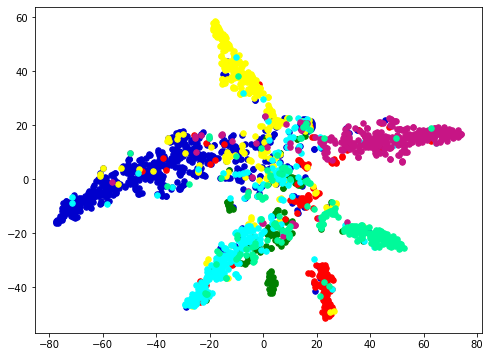

In [14]:
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt

import matplotlib


ts = TSNE(n_components=2)
ts.fit_transform(out[test_mask].to('cpu').detach().numpy())

x = ts.embedding_
y = cora.y[test_mask].to('cpu').detach().numpy()

xi = []
for i in range(7):
    xi.append(x[np.where(y==i)])

colors = ['mediumblue','green','red','yellow','cyan','mediumvioletred','mediumspringgreen']
plt.figure(figsize=(8, 6))
# plt.title('GAT_2_layer') 
for i in range(7):
    plt.scatter(xi[i][:,0],xi[i][:,1],s=30,color=colors[i],marker='o',alpha=1)
plt.savefig('./GAT_2_layer_(5678).png',dpi=300)

In [15]:
out[test_mask].shape

torch.Size([2068, 7])

In [16]:
out[test_mask][1].shape

torch.Size([7])

In [17]:
out[test_mask][1]

tensor([-4.2891, -4.9872, -5.4152, -0.0645, -4.2653, -3.9709, -5.3977],
       grad_fn=<SelectBackward>)

In [18]:
out[test_mask]

tensor([[-1.0707e+01, -1.1624e+01, -6.9165e-04,  ..., -8.3070e+00,
         -1.3295e+01, -7.7994e+00],
        [-4.2891e+00, -4.9872e+00, -5.4152e+00,  ..., -4.2653e+00,
         -3.9709e+00, -5.3977e+00],
        [-4.8098e+00, -6.0903e+00, -3.1213e-02,  ..., -4.1437e+00,
         -6.9009e+00, -5.9485e+00],
        ...,
        [-1.2877e+01, -1.4472e+01, -9.6128e+00,  ..., -1.0799e+01,
         -1.4854e+01, -9.1072e-05],
        [-1.0247e+00, -3.6571e+00, -8.8511e-01,  ..., -3.5568e+00,
         -5.0946e+00, -1.7979e+00],
        [-1.8146e+00, -1.0184e+01, -9.5751e+00,  ..., -1.0921e+01,
         -9.7935e+00, -8.9027e+00]], grad_fn=<IndexBackward>)

In [19]:
x

array([[ 23.614843, -47.376797],
       [ -3.396601,  32.076233],
       [ 22.343613, -33.608395],
       ...,
       [ 47.886562, -24.556023],
       [ 13.726906,  -8.284261],
       [-15.27283 ,  42.710846]], dtype=float32)

/Users/lianghuaxiong/anaconda3/envs/gcn_pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in power
  # This is added back by InteractiveShellApp.init_path()
/Users/lianghuaxiong/anaconda3/envs/gcn_pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/Users/lianghuaxiong/anaconda3/envs/gcn_pytorch/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


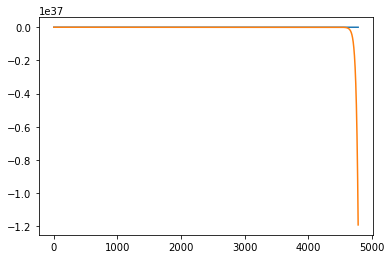

In [37]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import erf
from scipy.optimize import minimize,leastsq, curve_fit

e = np.e


def gauss(x):
    # return np.exp( -0.5 * x**2 / np.sqrt( 2 * np.pi ) )
    return (e**x + e**(-x)) /2


def Phi(x):
    return ( 0.5 * ( 1. + erf(x/np.sqrt(2) ) ) )


def skewed(x, x0, s, a):
    return 2./s * gauss( ( x - x0 ) / s ) * Phi( a * ( x - x0 ) / s)


def my_double_peak(x, A0, x0, s0, a, A1, x1, s1):
    return A0 * skewed( x, x0, s0, a ) + A1 / s1 * gauss( ( x - x1 ) / s1 )

data = np.loadtxt("051501.csv", skiprows=1, delimiter=',')
xData = range(len(data))

fitResult, ier = curve_fit( my_double_peak, xData, data[:,1], p0=(45e3, 400., 60,4. ,15e3, 700., 30 )  ) 

bestFit = [my_double_peak(x, *fitResult ) for x in range(len(data)) ]


fig1=plt.figure(1)
ax= fig1.add_subplot( 1, 1, 1 )
ax.plot( data[:,1] )
ax.plot( bestFit )

plt.show()

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd



e = np.e

def gauss(x,mu,sigma,A):
    # return A*np.exp(-(x-mu)**2/2/sigma**2)
    return (e**x + e**(-x)) /2

def bimodal(x,mu1,sigma1,A1,mu2,sigma2,A2):
    return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)

def rmse(p0):
    mu1,sigma1,A1,mu2,sigma2,A2 =p0
    y_sim = bimodal(x,mu1,sigma1,A1,mu2,sigma2,A2)
    rms = np.sqrt((y-y_sim)**2/len(y))

data = pd.read_csv('051501.csv')
# x, y = data.index, data['24hr'].values

# expected=(400,720,500,700,774,150)

# params,cov=curve_fit(bimodal,x,y,expected, maxfev=100000)
# sigma=np.sqrt(np.diag(cov))
# plt.plot(x,bimodal(x,*params),color='red',lw=3,label='model')
# plt.plot(x,y,label='data')
# plt.legend()
# print(params,'\n',sigma)

In [3]:
data = pd.read_csv('051501.csv')
len(data)

4788

[4. 2. 5. 7. 7. 1.] 
 [inf inf inf inf inf inf]


/Users/lianghuaxiong/anaconda3/envs/gcn_pytorch/lib/python3.7/site-packages/scipy/optimize/minpack.py:792: RuntimeWarning: overflow encountered in square
  cost = np.sum(infodict['fvec'] ** 2)
/Users/lianghuaxiong/anaconda3/envs/gcn_pytorch/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/Users/lianghuaxiong/anaconda3/envs/gcn_pytorch/lib/python3.7/site-packages/matplotlib/ticker.py:2222: RuntimeWarning: overflow encountered in multiply
  steps = self._extended_steps * scale


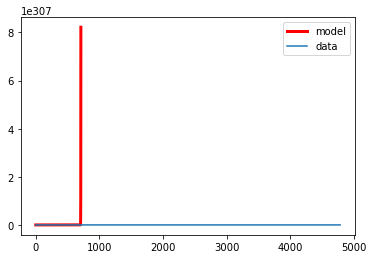

In [7]:
data.columns = ['a','b']
x, y = data.index, data['b'].values

expected=(4,2,5,7,7,1)

params,cov=curve_fit(bimodal,x,y,expected, maxfev=100000)
sigma=np.sqrt(np.diag(cov))
plt.plot(x,bimodal(x,*params),color='red',lw=3,label='model')
plt.plot(x,y,label='data')
plt.legend()
print(params,'\n',sigma)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import erf
from scipy.optimize import minimize,leastsq, curve_fit


def gauss(x):
    return np.exp( -0.5 * x**2 / np.sqrt( 2 * np.pi ) )


def Phi(x):
    return ( 0.5 * ( 1. + erf(x/np.sqrt(2) ) ) )


def skewed(x, x0, s, a):
    return 2./s * gauss( ( x - x0 ) / s ) * Phi( a * ( x - x0 ) / s)


def my_double_peak(x, A0, x0, s0, a, A1, x1, s1):
    return A0 * skewed( x, x0, s0, a ) + A1 / s1 * gauss( ( x - x1 ) / s1 )

data = np.loadtxt("5.csv", skiprows=1, delimiter=',')
xData = range(len(data))

fitResult, ier = curve_fit( my_double_peak, xData, data[:,1], p0=(45e3, 400., 60,4. ,15e3, 700., 30 ) ,bounds=(0, [80, 24., 0.2]) ) 

# popt, pcov = curve_fit(funl, x, y,bounds=(0, [80, 24., 0.2]))

bestFit = [my_double_peak(x, *fitResult ) for x in range(len(data)) ]


fig1=plt.figure(1)
ax= fig1.add_subplot( 1, 1, 1 )
ax.plot( data[:,1] )
ax.plot( bestFit )

plt.show()

KeyboardInterrupt: 